In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import mcfit
from lya_2pt.tracer import Tracer
from lya_2pt.tracer_utils import get_angle
from lya_2pt.interface import Interface
from scipy.constants import speed_of_light
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.interpolate import RegularGridInterpolator as RGI
from configparser import ConfigParser
from numba import njit

from astropy.io import fits
import fitsio

# Read two forests from one healpix and initialize computation

In [2]:
rp_min = 0
rp_max = 200
rt_max = 200
rp_size = 50
rt_size = 50

In [3]:
config = ConfigParser()
config.read('lyaxlya_cf.ini')
lya2pt = Interface(config)
lya2pt.read_tracers()

In [6]:
wave1 = 10**lya2pt.tracers1[1011][0].log_lambda
deltas1 = lya2pt.tracers1[1011][0].deltas
weights1 = lya2pt.tracers1[1011][0].weights
dc1 = lya2pt.tracers1[1011][0].comoving_distance
dm1 = lya2pt.tracers1[1011][0].comoving_transverse_distance
z1 = lya2pt.tracers1[1011][0].z

wave2 = 10**lya2pt.tracers1[1011][1].log_lambda
deltas2 = lya2pt.tracers1[1011][1].deltas
weights2 = lya2pt.tracers1[1011][1].weights
dc2 = lya2pt.tracers1[1011][1].comoving_distance
dm2 = lya2pt.tracers1[1011][1].comoving_transverse_distance
z2 = lya2pt.tracers1[1011][1].z

tracer1 = lya2pt.tracers1[1011][0]
tracer2 = lya2pt.tracers1[1011][1]
angle = get_angle(tracer1.x_cart, tracer1.y_cart, tracer1.z_cart, tracer1.ra, tracer1.dec, tracer2.x_cart, tracer2.y_cart, tracer2.z_cart, tracer2.ra, tracer2.dec)

xi_grid = np.zeros(2500)

size1 = dc1.size
size2 = dc2.size
wave_bin_size = 2.4

In [7]:
rp = np.abs(np.subtract.outer(dc1, dc2) * np.cos(angle/2))
rt = np.add.outer(dm1, dm2) * np.sin(angle/2)

xi = np.outer(deltas1 * weights1, deltas2 * weights2)
xi_weights = np.outer(weights1, weights2)

mask = (rp >= rp_min) & (rp < rp_max) & (rt < rt_max)

rp = rp[mask]
rt = rt[mask]
xi = xi[mask]
xi_weights = xi_weights[mask]

bins_rp = np.floor((rp - rp_min) / (rp_max - rp_min) * rp_size).astype(int)
bins_rt = np.floor(rt / rt_max * rt_size).astype(int)
bins = (bins_rt + rt_size * bins_rp).astype(int).flatten()
# bins = (bins_rp + rp_size * bins_rt).astype(int).flatten()

rebin_xi = np.bincount(bins)#, weights=xi.flatten())
rebin_size = len(rebin_xi)
total_size = rt_size * rp_size

xi_grid[:rebin_size] += rebin_xi[:total_size]

Text(0, 0.5, '$r_{||}$')

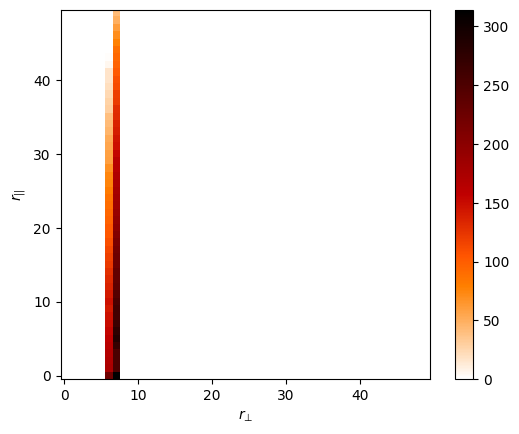

In [47]:
# np.unique(binsR
plt.imshow(xi_grid.reshape(50,50), origin='lower', cmap='gist_heat_r', vmin=0)
plt.colorbar()
plt.xlabel(r'$r_\bot$')
plt.ylabel(r'$r_{||}$')

# Build fiducial P(k)

In [8]:
def fiducial_Pk(kv, z, A=0.066, k0=0.009, z0=3.0, n=-2.685, alpha=-0.22, k1=0.053, B=3.59, beta=-0.18):
    log_k_k0 = np.log(kv / k0 + 1e-10)
    pk = A * np.power(kv / k0, 2 + n + alpha * log_k_k0) / (1 + (kv / k1)**2)
    z_evol = np.power((1 + z) / (1 + z0), B + beta * log_k_k0)
    return pk * z_evol * np.pi / k0

def fiducial_Pk_angstrom(kA, z, A=0.066, k0=0.009, z0=3.0, n=-2.685, alpha=-0.22, k1=0.053, B=3.59, beta=-0.18):
    kv = kA * 1215.67 * (1 + z) / (speed_of_light / 1000) 
    return fiducial_Pk(kv, z, A, k0, z0, n, alpha, k1, B, beta) * 1215.67 * (1 + z) / (speed_of_light / 1000)


def window_squared(k, z, delta_lambda=0.8):
    delta_v = speed_of_light / 1000 * delta_lambda / (1215.67 * (1 + z))
    R = delta_v
    return (np.exp(-k**2 * R**2 / 2) * np.sinc(k * delta_v / 2 / np.pi))**2

def window_squared_angstrom(k, delta_lambda=2.4, R=0.8):
    return (np.exp(-k**2 * R**2 / 2) * np.sinc(k * delta_lambda / 2 / np.pi))**2

In [9]:
z = 2.2
# dv = speed_of_light / 1000 * delta_lambda / (1215.67 * (1 + z))
dv = 1
r = dv * np.arange(2**20) - 2**19
k = np.fft.rfftfreq(r.size, d=dv) * 2 * np.pi

# k = np.linspace(0, 1000, 1000000)
fid_pk = fiducial_Pk(k, z)
xi = np.fft.irfft(window_squared(k, z) * fid_pk) / dv
xi = np.fft.fftshift(xi)


Text(0.5, 0, '$k [\\AA]^{-1}$')

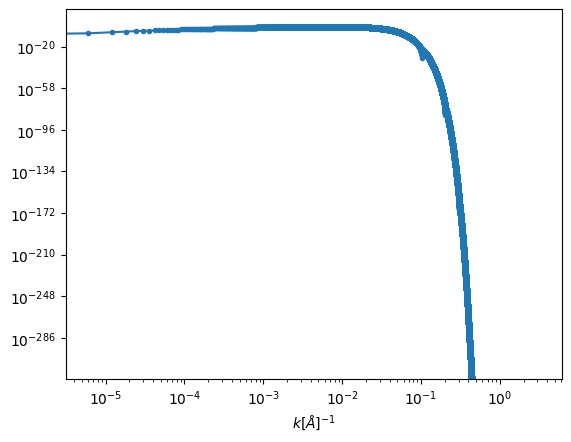

In [14]:
# plt.loglog(k, fid_pk)

plt.loglog(k, fid_pk * window_squared(k, z) * k / np.pi, '.-')
# plt.loglog(k, fid_pk_angstrom * k / np.pi, '.-')
plt.xlabel(r'$k [\AA]^{-1}$')
# plt.axvline(2*np.pi/0.8, c='k', ls='--')
# plt.axvline(2*np.pi/1000, c='k', ls='--')

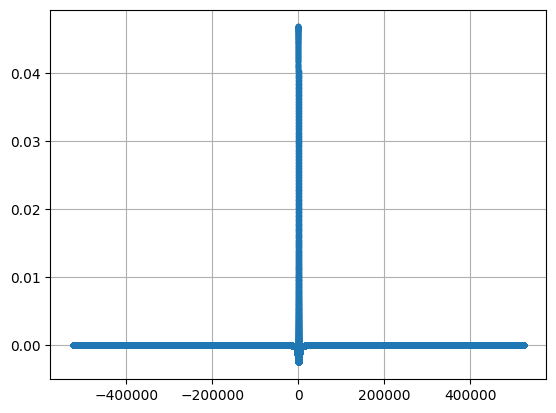

In [15]:
plt.plot(r, xi, '.')
# plt.xlim(-100,100)
# plt.ylim(0.09, 0.092)
plt.grid()

In [16]:
z = 2.2
dlambda = 0.01
r = dlambda * (np.arange(2**20) - 2**19)
k = np.fft.rfftfreq(r.size, d=dlambda) * 2 * np.pi

fid_pk_angstrom = fiducial_Pk_angstrom(k, z)

xi = np.fft.irfft(fid_pk_angstrom) / dlambda
xi = np.fft.fftshift(xi)

xi_wwindow = np.fft.irfft(fid_pk_angstrom * window_squared_angstrom(k)) / dlambda
xi_wwindow = np.fft.fftshift(xi_wwindow)

Text(0.5, 0, '$k [\\AA]^{-1}$')

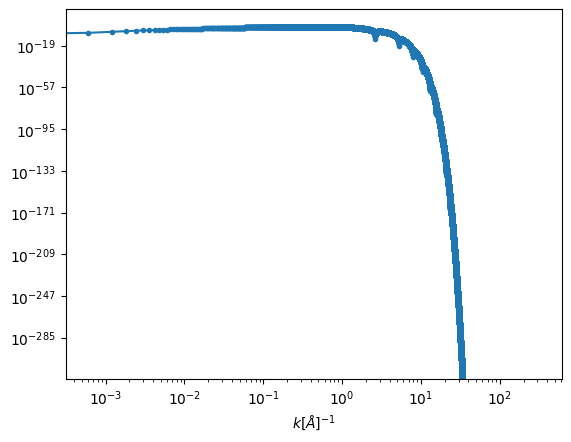

In [17]:
# plt.loglog(k, fid_pk)

# plt.loglog(k, fid_pk * k / np.pi, '.-')
plt.loglog(k, fid_pk_angstrom * window_squared_angstrom(k) * k / np.pi, '.-')
plt.xlabel(r'$k [\AA]^{-1}$')
# plt.axvline(2*np.pi/0.8, c='k', ls='--')
# plt.axvline(2*np.pi/1000, c='k', ls='--')

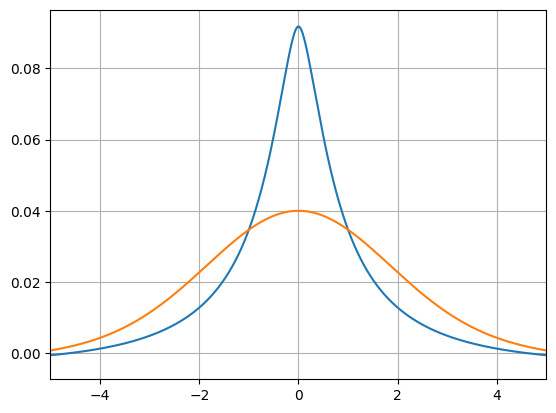

In [18]:
plt.plot(r, xi, '-')
plt.plot(r, xi_wwindow, '-')
plt.xlim(-5,5)
# plt.ylim(0.09, 0.092)
plt.grid()

# Build $\xi_{1D}$ interpolation

In [19]:
z = np.linspace(1.8, 4, 50)

dlambda = 0.01
r = dlambda * (np.arange(2**20) - 2**19)
k = np.fft.rfftfreq(r.size, d=dlambda) * 2 * np.pi

kk, zz = np.meshgrid(k, z)

fid_pk_angstrom = fiducial_Pk_angstrom(kk, zz)

xi_wwindow = np.fft.irfft(fid_pk_angstrom * window_squared_angstrom(k)) / dlambda
xi_wwindow = np.fft.fftshift(xi_wwindow)

xi_interp = RGI((r, z), xi_wwindow.T, method='linear', bounds_error=False)

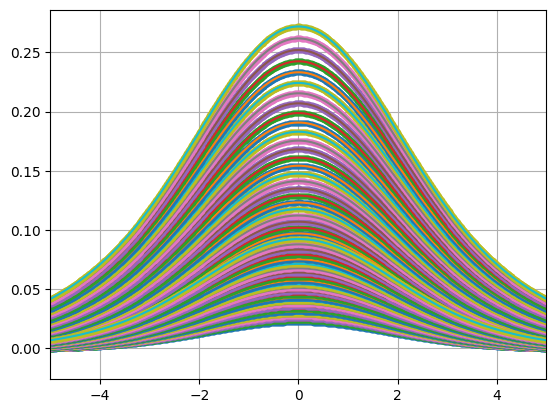

In [20]:
for i, xi in enumerate(xi_wwindow):
    plt.plot(r + 0.005, xi_interp((r + 0.005, z[i])), '.')
    
    plt.plot(r, xi, '-')

plt.xlim(-5,5)
# plt.ylim(0.09, 0.092)
plt.grid()

# Build covariance matrices for the two forests

In [447]:
# %%timeit

z_ij = np.sqrt((1 + z1[:, None]) * (1 + z1[None, :])) - 1
indeces = np.arange(size1)
delta_lambdas = np.abs(indeces[:, None] - indeces[None, :]) * wave_bin_size
cov1 = xi_interp((delta_lambdas, z_ij))

np.fill_diagonal(cov1, cov1.diagonal() + 1/weights1)
invcov1 = np.linalg.inv(cov1)

In [448]:
z_ij = np.sqrt((1 + z2[:, None]) * (1 + z2[None, :])) - 1
indeces = np.arange(size2)
delta_lambdas = np.abs(indeces[:, None] - indeces[None, :]) * wave_bin_size
cov2 = xi_interp((delta_lambdas, z_ij))

np.fill_diagonal(cov2, cov2.diagonal() + 1/weights2)
invcov2 = np.linalg.inv(cov2)

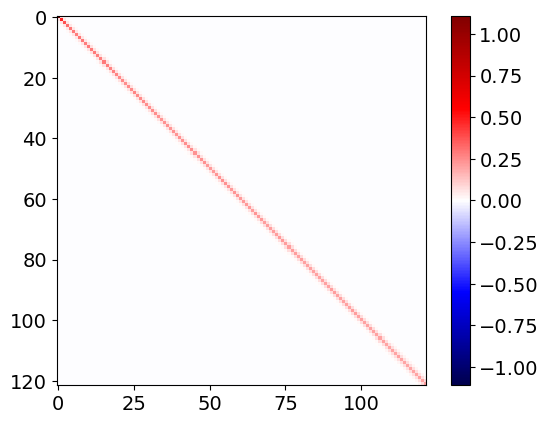

In [440]:
plt.imshow(cov1, cmap='seismic', vmin=-np.max(np.abs(cov1)), vmax=np.max(np.abs(cov1)))
plt.colorbar()

# Compute bins and populate $C_{,i}$

In [444]:
rp = np.abs(np.subtract.outer(dc1, dc2) * np.cos(angle/2))
rt = np.add.outer(dm1, dm2) * np.sin(angle/2)

xi = np.outer(deltas1 * weights1, deltas2 * weights2)
xi_weights = np.outer(weights1, weights2)

mask = (rp >= rp_min) & (rp < rp_max) & (rt < rt_max)

# rp = rp[mask]
# rt = rt[mask]

bins_rp = np.floor((rp - rp_min) / (rp_max - rp_min) * rp_size).astype(int)
bins_rt = np.floor(rt / rt_max * rt_size).astype(int)
bins = (bins_rt + rt_size * bins_rp).astype(int)


In [445]:
bins

array([[   6,    6,    6, ..., 2457, 2507, 2507],
       [   6,    6,    6, ..., 2457, 2457, 2507],
       [   6,    6,    6, ..., 2407, 2457, 2457],
       ...,
       [2807, 2757, 2757, ...,  307,  257,  257],
       [2807, 2757, 2757, ...,  307,  307,  257],
       [2807, 2807, 2757, ...,  357,  307,  307]])

Text(0.5, 1.0, '$C_1^{-1}C_{,i}C_2^{-1}$')

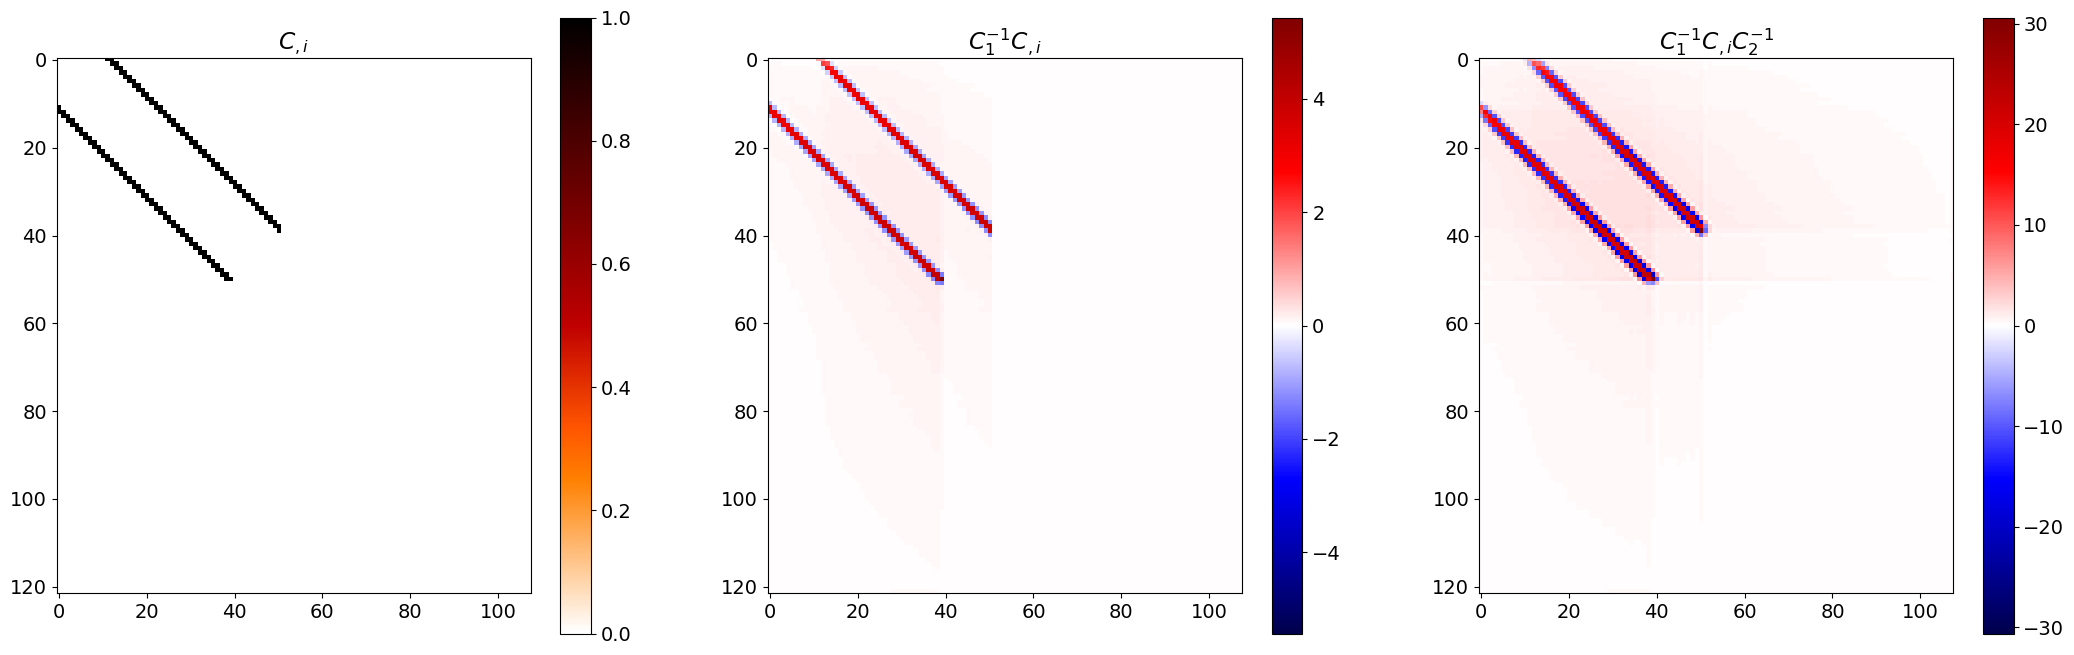

In [446]:
plt.rcParams['font.size'] = 14

i = 10
bin_index = np.unique(bins)[i]
mask2 = np.array(np.where((bins==bin_index)))

fig, ax = plt.subplots(1, 3, figsize=(26,8))
c_deriv = np.zeros(xi.shape)
c_deriv[mask2[0], mask2[1]] = 1

cov1_c_deriv = np.matmul(np.linalg.inv(cov1), c_deriv)
cov1_c_deriv_cov2 = np.matmul(np.matmul(np.linalg.inv(cov1), c_deriv), np.linalg.inv(cov2))

a = ax[0].imshow(c_deriv, cmap='gist_heat_r', vmin=0)
b = ax[1].imshow(cov1_c_deriv, cmap='seismic', vmin=-np.max(np.abs(cov1_c_deriv)), vmax=np.max(np.abs(cov1_c_deriv)))
fig.colorbar(a, ax=ax[0])
fig.colorbar(b, ax=ax[1])

c = ax[2].imshow(cov1_c_deriv_cov2, cmap='seismic', vmin=-np.max(np.abs(cov1_c_deriv_cov2)), vmax=np.max(np.abs(cov1_c_deriv_cov2)))
fig.colorbar(c, ax=ax[2])

ax[0].set_title(r'$C_{,i}$')
ax[1].set_title(r'$C_1^{-1}C_{,i}$')
ax[2].set_title(r'$C_1^{-1}C_{,i}C_2^{-1}$')

# plt.colorbar()

# Compute matrices for all $\xi$ bins

In [449]:
def build_deriv(xi_size, dc1, dc2, dm1, dm2, angle):
    rp = np.abs(np.subtract.outer(dc1, dc2) * np.cos(angle/2))
    rt = np.add.outer(dm1, dm2) * np.sin(angle/2)

    mask = (rp >= rp_min) & (rp < rp_max) & (rt < rt_max)

    bins_rp = np.floor((rp - rp_min) / (rp_max - rp_min) * rp_size).astype(int)
    bins_rt = np.floor(rt / rt_max * rt_size).astype(int)
    bins = (bins_rt + rt_size * bins_rp).astype(int)

    c_deriv_dict = {}
    c_deriv_masks = {}
    for bin_index in np.unique(bins):
        if bin_index >= xi_size:
            continue

        mask2 = np.array(np.where(bins == bin_index)).T
        mask2 = mask2[mask2[:, 1].argsort()].T

        c_deriv_dict[bin_index] = np.zeros(xi.shape)
        c_deriv_dict[bin_index][mask2[0], mask2[1]] = 1
        c_deriv_masks[bin_index] = mask2
    
    return c_deriv_dict, c_deriv_masks

def c_inv_times_c_deriv(invcov, c_deriv_dict, transpose=False):
    c_inv_times_c_deriv_dict = {}
    for key, c_deriv in c_deriv_dict.items():
        if transpose:
            c_inv_times_c_deriv_dict[key] = np.matmul(invcov, c_deriv.T)
        else:
            c_inv_times_c_deriv_dict[key] = np.matmul(invcov, c_deriv)
    return c_inv_times_c_deriv_dict

# def c_inv_times_c_deriv(invcov, c_deriv):
#     return np.matmul(invcov, c_deriv)

In [450]:
c_deriv_dict, c_deriv_masks = build_deriv(2500, dc1, dc2, dm1, dm2, angle)

In [116]:
%timeit c_deriv_dict, _ = build_deriv(2500, dc1, dc2, dm1, dm2, angle)

4.81 ms ± 17.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [451]:
c1_inv_times_c_deriv_dict = c_inv_times_c_deriv(invcov1, c_deriv_dict)

In [141]:
%timeit c_inv_times_c_deriv_dict = c_inv_times_c_deriv(invcov1, c_deriv_dict)

12.1 ms ± 1.23 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [452]:
c2_inv_times_c_deriv_dict = c_inv_times_c_deriv(invcov2, c_deriv_dict, transpose=True)

In [142]:
%timeit c2_inv_times_c_deriv_dict = c_inv_times_c_deriv(invcov2, c_deriv_dict, transpose=True)

11.3 ms ± 90.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [125]:
c_inv_times_c_deriv_dict.keys()

dict_keys([6, 7, 56, 57, 106, 107, 156, 157, 206, 207, 256, 257, 306, 307, 356, 357, 406, 407, 456, 457, 506, 507, 556, 557, 606, 607, 656, 657, 706, 707, 756, 757, 806, 807, 856, 857, 906, 907, 956, 957, 1006, 1007, 1056, 1057, 1106, 1107, 1156, 1157, 1206, 1207, 1256, 1257, 1306, 1307, 1356, 1357, 1406, 1407, 1456, 1457, 1506, 1507, 1556, 1557, 1606, 1607, 1656, 1657, 1706, 1707, 1756, 1757, 1806, 1807, 1856, 1857, 1906, 1907, 1956, 1957, 2006, 2007, 2056, 2057, 2106, 2107, 2156, 2157, 2207, 2257, 2307, 2357, 2407, 2457])

Text(0.5, 1.0, '$C_1^{-1}C_{,i}C_2^{-1}$')

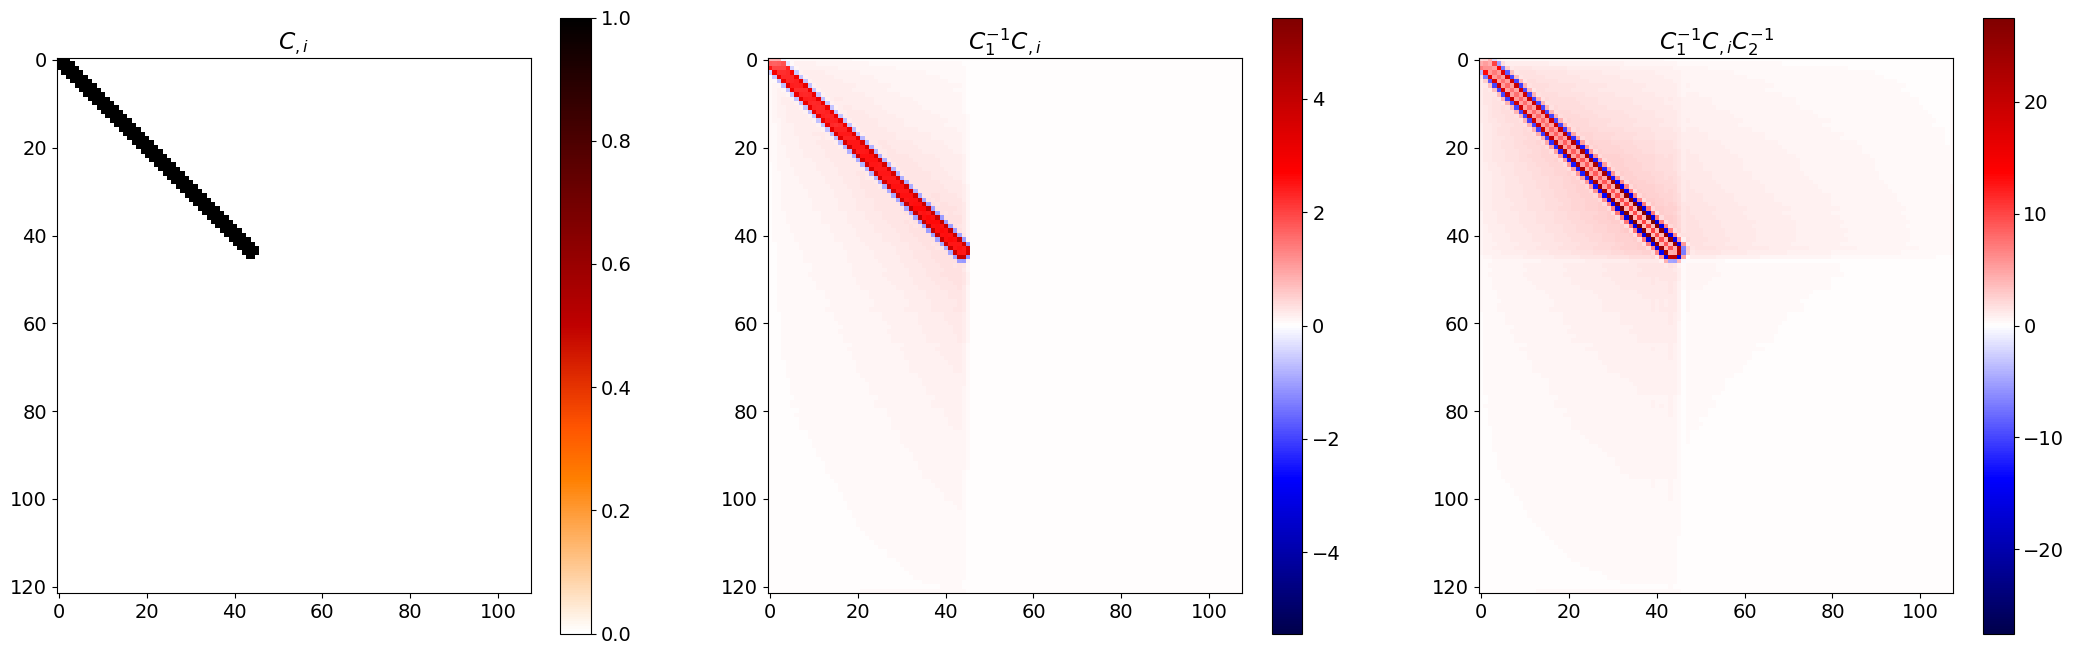

In [453]:
plt.rcParams['font.size'] = 14

i = 6

fig, ax = plt.subplots(1, 3, figsize=(26,8))

cov1_c_deriv_cov2 = np.matmul(c1_inv_times_c_deriv_dict[i], invcov2)

a = ax[0].imshow(c_deriv_dict[i], cmap='gist_heat_r', vmin=0)
b = ax[1].imshow(c1_inv_times_c_deriv_dict[i], cmap='seismic', vmin=-np.max(np.abs(cov1_c_deriv)), vmax=np.max(np.abs(cov1_c_deriv)))
fig.colorbar(a, ax=ax[0])
fig.colorbar(b, ax=ax[1])

c = ax[2].imshow(cov1_c_deriv_cov2, cmap='seismic', vmin=-np.max(np.abs(cov1_c_deriv_cov2)), vmax=np.max(np.abs(cov1_c_deriv_cov2)))
fig.colorbar(c, ax=ax[2])

ax[0].set_title(r'$C_{,i}$')
ax[1].set_title(r'$C_1^{-1}C_{,i}$')
ax[2].set_title(r'$C_1^{-1}C_{,i}C_2^{-1}$')

# Try manual matrix multiplication

In [454]:
# @njit('f8[:,:](f8[:,:], i8[:,:])')
def compute_matmul(invcov, mask, transpose=False):
    c_deriv = np.zeros(xi.shape, dtype=np.float_)
    c_deriv[mask[0], mask[1]] = 1
    
    if transpose:
        return invcov@c_deriv.T
    else:
        return invcov@c_deriv

@njit
def compute_raw(invcov, mask, size1, size2):
    prod = np.zeros((size1, size2))
    mask_size = len(mask[1])

    start = 0
    end = 0
    for i, col_idx in enumerate(mask[1]):
        if i == (mask_size - 1):
            row_idx = mask[0][start:mask_size]
            prod[:, col_idx] += np.sum(invcov[:, row_idx], axis=1)
            
            start = i + 1
            end = i + 1
        elif mask[1][i+1] != col_idx:
            row_idx = mask[0][start:i+1]
            prod[:, col_idx] += np.sum(invcov[:, row_idx], axis=1)
            
            start = i + 1
            end = i + 1
        else:
            end += 1
            
    return prod
        
        
    # for i in range(size1):
    #     for j in range(size2):
    #         if 

In [367]:
test1 = compute_matmul(invcov1, c_deriv_masks[6])

In [378]:
%%timeit

for mask in c_deriv_masks.values():
    compute_matmul(invcov1, mask)

17.2 ms ± 304 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [369]:
test2 = compute_raw(invcov1, c_deriv_masks[6], size1, size2)

In [379]:
%%timeit 

for mask in c_deriv_masks.values():
    compute_raw(invcov1, mask, size1, size2)

5.74 ms ± 77.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


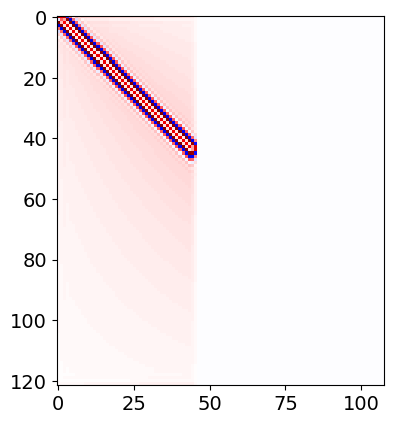

In [200]:
plt.imshow(test2, cmap='seismic', vmin=-np.max(np.abs(test2)), vmax=np.max(np.abs(test2)))

In [371]:
np.allclose(test1, test2)

True

In [372]:
test3 = compute_matmul(invcov2, c_deriv_masks[6], transpose=True)
test4 = compute_raw(invcov2, c_deriv_masks[6][::-1], size2, size1)

In [382]:
%%timeit
for mask in c_deriv_masks.values():
    compute_matmul(invcov2, mask, transpose=True)

13.8 ms ± 366 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [383]:
%%timeit 
for mask in c_deriv_masks.values():
    compute_raw(invcov2, mask[::-1], size2, size1)

7.99 ms ± 144 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [384]:
np.allclose(test3, test4)

True

In [345]:
%timeit c_deriv_masks[6][::-1]

181 ns ± 1.86 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


# Benchmark order of operations

In [455]:
def test_v1(deltas1, deltas2, invcov1, invcov2, c_deriv_masks, xi_est, fisher):
    c_deriv_dict = {}
    for key, mask1 in c_deriv_masks.items():
        c_deriv_dict[key] = np.zeros((deltas1.size, deltas2.size), dtype=np.float_)
        c_deriv_dict[key][mask1[0], mask1[1]] = 1

    for key1, c_deriv1 in c_deriv_dict.items():
        xi = c_deriv1@(invcov2@deltas2)
        xi = 2 * (deltas1@invcov1)@xi
        
        xi_est[key1] += xi

        c1_inv_times_c_deriv = invcov1@c_deriv1
        
        for key2, c_deriv2 in c_deriv_dict.items():
            c2_inv_times_c_deriv = invcov2@c_deriv2.T

            fisher[key1, key2] += c1_inv_times_c_deriv.flatten().dot(c2_inv_times_c_deriv.flatten())

def test_v2(deltas1, deltas2, invcov1, invcov2, c_deriv_masks, xi_est, fisher):
    for key1, mask1 in c_deriv_masks.items():
        c_deriv1 = np.zeros((deltas1.size, deltas2.size), dtype=np.float_)
        c_deriv1[mask1[0], mask1[1]] = 1

        xi = c_deriv1@(invcov2@deltas2)
        xi = 2 * (deltas1@invcov1)@xi
        
        xi_est[key1] += xi

        c1_inv_times_c_deriv = invcov1@c_deriv1
        
        for key2, mask2 in c_deriv_masks.items():
            c2_inv_times_c_deriv = compute_raw(invcov2, mask2[::-1], deltas2.size, deltas1.size)

            fisher[key1, key2] += c1_inv_times_c_deriv.flatten().dot(c2_inv_times_c_deriv.flatten())
            
def test_v3(deltas1, deltas2, invcov1, invcov2, c_deriv_masks, xi_est, fisher):
    for key1, mask1 in c_deriv_masks.items():
        c_deriv1 = np.zeros((deltas1.size, deltas2.size), dtype=np.float_)
        c_deriv1[mask1[0], mask1[1]] = 1

        xi = c_deriv1@(invcov2@deltas2)
        xi = 2 * (deltas1@invcov1)@xi
        
        xi_est[key1] += xi

        c1_inv_times_c_deriv = compute_raw(invcov1, mask1, deltas1.size, deltas2.size)
        
        for key2, mask2 in c_deriv_masks.items():
            c2_inv_times_c_deriv = compute_raw(invcov2, mask2[::-1], deltas2.size, deltas1.size)

            fisher[key1, key2] += c1_inv_times_c_deriv.flatten().dot(c2_inv_times_c_deriv.flatten())


def test_v4(deltas1, deltas2, invcov1, invcov2, c_deriv_masks, xi_est, fisher):
    for key1, mask1 in c_deriv_masks.items():
        c1_inv_times_c_deriv = compute_raw(invcov1, mask1, deltas1.size, deltas2.size)
        c1_inv_times_c_deriv_times_c2_inv = c1_inv_times_c_deriv@invcov2

        xi_est[key1] += 2 * deltas1@c1_inv_times_c_deriv_times_c2_inv@deltas2
        
        for key2, mask2 in c_deriv_masks.items():
            fisher[key1, key2] += np.trace(compute_raw(c1_inv_times_c_deriv_times_c2_inv, mask2[::-1], deltas2.size, deltas1.size))
 

In [456]:
xi_est_v1 = np.zeros(2500)
fisher_v1 = np.zeros((2500, 2500))
test_v1(deltas1, deltas2, invcov1, invcov2, c_deriv_masks, xi_est_v1, fisher_v1)

xi_est_v2 = np.zeros(2500)
fisher_v2 = np.zeros((2500, 2500))
test_v2(deltas1, deltas2, invcov1, invcov2, c_deriv_masks, xi_est_v2, fisher_v2)

xi_est_v3 = np.zeros(2500)
fisher_v3 = np.zeros((2500, 2500))
test_v3(deltas1, deltas2, invcov1, invcov2, c_deriv_masks, xi_est_v3, fisher_v3)

In [397]:
xi_est_v4 = np.zeros(2500)
fisher_v4 = np.zeros((2500, 2500))
test_v4(deltas1, deltas2, invcov1, invcov2, c_deriv_masks, xi_est_v4, fisher_v4)

In [398]:
%timeit test_v1(deltas1, deltas2, invcov1, invcov2, c_deriv_masks, xi_est, fisher)

1.38 s ± 27.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [399]:
%timeit test_v2(deltas1, deltas2, invcov1, invcov2, c_deriv_masks, xi_est, fisher)

1.15 s ± 21 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [400]:
%timeit test_v3(deltas1, deltas2, invcov1, invcov2, c_deriv_masks, xi_est, fisher)

1.14 s ± 7.21 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [401]:
%timeit test_v4(deltas1, deltas2, invcov1, invcov2, c_deriv_masks, xi_est, fisher)

891 ms ± 4.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [388]:
np.allclose(xi_est_v1, xi_est_v4)

True

In [387]:
np.allclose(fisher_v1, fisher_v4)

False

# Build full estimation code for 1 forest pair
## $E_i = 2 d_1^T C_1^{-1} C_{,i} C_2^{-1} d_2$
## $F_{ij} = Tr(C_1^{-1} C_{,i} C_2^{-1} C_{,j})$

In [214]:
@njit
def fast_sparse_matmul(invcov, mask, size1, size2):
    prod = np.zeros((size1, size2))
    mask_size = len(mask[1])

    start = 0
    end = 0
    for i, col_idx in enumerate(mask[1]):
        if i == (mask_size - 1):
            row_idx = mask[0][start:mask_size]
            prod[:, col_idx] += np.sum(invcov[:, row_idx], axis=1)
            
            start = i + 1
            end = i + 1
        elif mask[1][i+1] != col_idx:
            row_idx = mask[0][start:i+1]
            prod[:, col_idx] += np.sum(invcov[:, row_idx], axis=1)
            
            start = i + 1
            end = i + 1
        else:
            end += 1
            
    return prod

def compute_bins(dc1, dc2, dm1, dm2, angle):
    rp = np.abs(np.subtract.outer(dc1, dc2) * np.cos(angle/2))
    rt = np.add.outer(dm1, dm2) * np.sin(angle/2)

    bins_rp = np.floor((rp - rp_min) / (rp_max - rp_min) * rp_size).astype(int)
    bins_rt = np.floor(rt / rt_max * rt_size).astype(int)
    bins = (bins_rt + rt_size * bins_rp).astype(int)
    
    return bins

def compute_pair(dc1, dc2, dm1, dm2, angle, xi_est, fisher):
    bins = compute_bins(dc1, dc2, dm1, dm2, angle)

    # c_deriv_dict = {}
    # c_deriv_masks = {}
    for bin_index in np.unique(bins):
        if bin_index >= xi_est.size:
            continue

        mask = np.array(np.where(bins == bin_index)).T
        mask = mask[mask[:, 1].argsort()].T
        
        

        # c_deriv_dict[bin_index] = np.zeros(xi.shape)
        # c_deriv_dict[bin_index][mask2[0], mask2[1]] = 1
        # c_deriv_masks[bin_index] = mask2
    
    return c_deriv_dict, c_deriv_masks

def c_inv_times_c_deriv(invcov, c_deriv_dict, transpose=False):
    c_inv_times_c_deriv_dict = {}
    for key, c_deriv in c_deriv_dict.items():
        if transpose:
            c_inv_times_c_deriv_dict[key] = np.matmul(invcov, c_deriv.T)
        else:
            c_inv_times_c_deriv_dict[key] = np.matmul(invcov, c_deriv)
    return c_inv_times_c_deriv_dict

array([[ 0,  1,  2,  0,  1,  2,  3,  0,  1,  2,  4,  3,  5,  4,  3,  2,
         1,  3,  2,  4,  5,  6,  3,  4,  5,  7,  6,  8,  7,  6,  5,  4,
         6,  5,  7,  8,  9,  6,  7,  8, 10,  9, 11, 10,  9,  8,  7,  9,
         8, 10, 11, 12,  9, 10, 11, 13, 12, 14, 13, 12, 11, 10, 12, 11,
        13, 14, 15, 12, 13, 14, 16, 15, 17, 16, 15, 14, 13, 15, 14, 16,
        17, 18, 15, 16, 17, 19, 18, 20, 19, 18, 17, 16, 18, 17, 19, 20,
        21, 18, 19, 20, 22, 21, 23, 22, 21, 20, 19, 21, 20, 22, 23, 24,
        21, 22, 23, 25, 24, 26, 25, 22, 23, 24, 24, 23, 25, 26, 27, 24,
        25, 26, 28, 27, 29, 28, 27, 26, 25, 27, 26, 28, 29, 30, 27, 28,
        29, 31, 30, 32, 31, 30, 29, 28, 30, 29, 31, 32, 33, 30, 31, 32,
        34, 33, 35, 34, 33, 32, 31, 33, 32, 34, 35, 36, 33, 34, 35, 37,
        36, 38, 37, 34, 35, 36, 36, 35, 37, 38, 39, 36, 37, 38, 40, 39,
        41, 40, 39, 38, 37, 39, 38, 40, 41, 42, 39, 40, 41, 43, 42, 44,
        43, 40, 41, 42, 42, 41, 43, 45, 44, 42, 43, 44, 45, 43, 

In [460]:
0.1 * 100 * 400000 / 3600 / 128

8.680555555555555

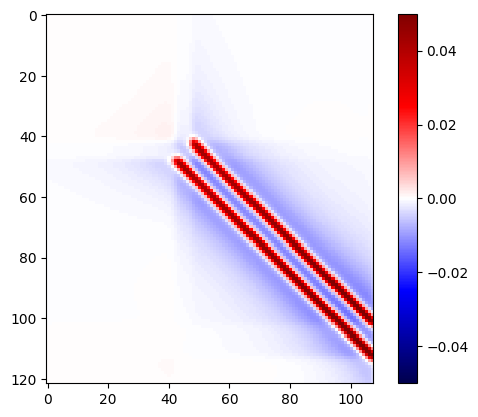

In [60]:
### cov2 = np.ones((dc2.size, dc2.size))
# cov2 = np.eye(dc2.size)


In [409]:
len(list(c_deriv_masks.keys()))

94

/tmp/ipykernel_9663/649520731.py:1: RuntimeWarning: invalid value encountered in sqrt
  correlation_mat = np.sqrt(fisher_v2.diagonal())
/tmp/ipykernel_9663/649520731.py:3: RuntimeWarning: invalid value encountered in divide
  correlation_mat = fisher_v2 / correlation_mat


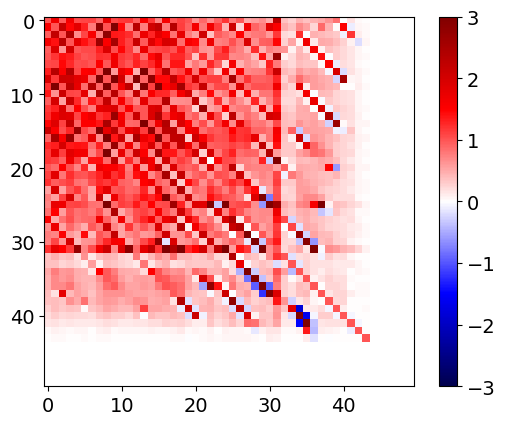

In [458]:
correlation_mat = np.sqrt(fisher_v2.diagonal())
correlation_mat = np.outer(correlation_mat, correlation_mat)
correlation_mat = fisher_v2 / correlation_mat
plt.imshow(correlation_mat[6::50,6::50], cmap='seismic', vmin=-3, vmax=3)
plt.colorbar()

In [429]:
mask = np.where(fisher_v2 != 0)

In [430]:
fisher_v2[mask]

array([1127.31223649,  906.54108646,  904.63091854, ...,  -21.30305447,
          4.81868201,  221.22508172])

In [431]:
 np.where(fisher_v2 != 0)

(array([   6,    6,    6, ..., 2457, 2457, 2457]),
 array([   6,    7,   56, ..., 2357, 2407, 2457]))

In [433]:
correlation_mat[6::50,6::50]

array([[1.        , 1.21045499, 0.61008036, ...,        nan,        nan,
               nan],
       [1.35705174, 1.        , 1.07767887, ...,        nan,        nan,
               nan],
       [0.60072456, 1.22742292, 1.        , ...,        nan,        nan,
               nan],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]])